In [7]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torch import tensor
from matplotlib import pyplot as plt
from src.models.cnn import CNN
from tqdm.notebook import tqdm

In [8]:
from src.preprocessors.dasps import DaspsPreprocessor

trials = DaspsPreprocessor.get_trials(duration=15, autoreject=False)

Getting epochs for filename data/dasps_raw_mat/S01.mat
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=14, n_times=3840
    Range : 0 ... 3839 =      0.000 ...    29.992 secs
Ready.
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Getting epochs for filename data/dasps_raw_mat/S01.mat
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=14, n_times=3840
    Range : 0 ... 3839 =      0.000 ...    29.992 secs
Ready.
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Getting epochs for filename data/dasps_raw_mat/S02.mat
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=14, n_ti

In [9]:
for trial in tqdm(trials):
    trial.compute_powers(False)

  0%|          | 0/384 [00:00<?, ?it/s]

In [10]:
from src.utils import oversample

oversampled_trials = oversample(trials)
oversampled_trials.shape

(468,)

In [11]:
from sklearn.model_selection import train_test_split
from src.models.cnn import RatiosCnnDataset, RatiosCNN

def train_and_evaluate():
    # Train
    trials_train, trials_test = train_test_split(oversampled_trials, train_size=0.8)

    train_dataset = RatiosCnnDataset(trials_train)
    test_dataset = RatiosCnnDataset(trials_test)

    num_epochs = 200
    batch_size = 32

    model = RatiosCNN(2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data, targets in train_loader:
            t = tensor(data, dtype=torch.float32)

            scores = model.forward(t)
            loss = criterion(scores, targets)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            losses.append(loss.item())

    # Evaluate
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for data, labels in test_loader:
            scores = model.forward(tensor(data, dtype=torch.float32))

            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)

    plt.figure(figsize=(20, 5))
    plt.ylim(0, 1)
    plt.plot(losses)

    return num_correct/num_samples


  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/wg/8xzwtj0n6fd93r4pqlr_bv1c0000gn/T/ipykernel_13480/3349516608.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = tensor(data, dtype=torch.float32)
/var/folders/wg/8xzwtj0n6fd93r4pqlr_bv1c0000gn/T/ipykernel_13480/3349516608.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = model.forward(tensor(data, dtype=torch.float32))


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.8148936

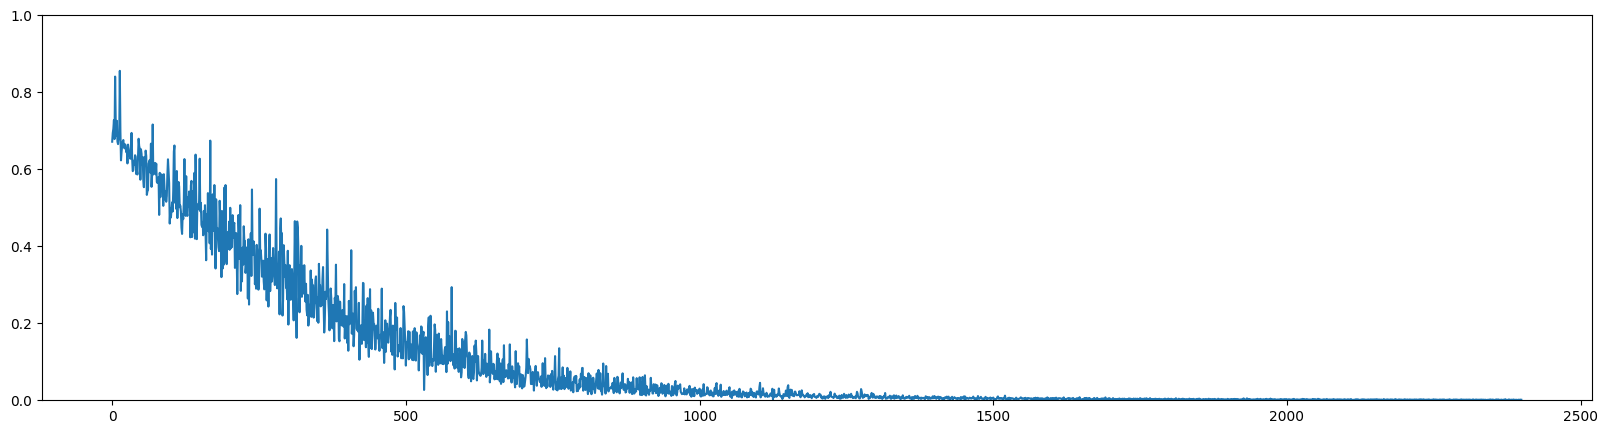

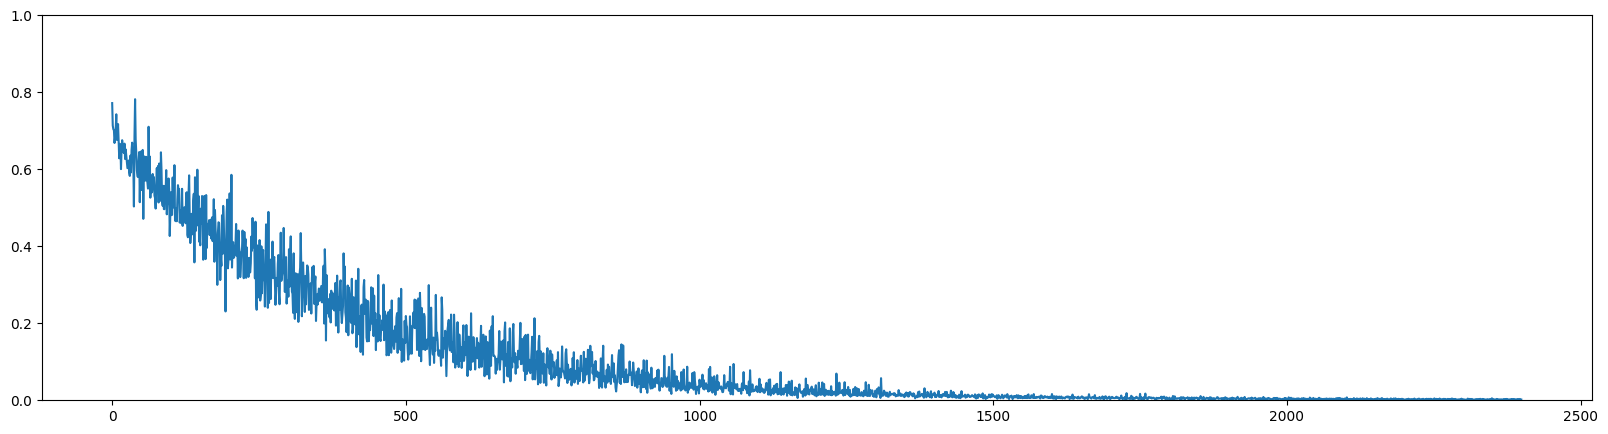

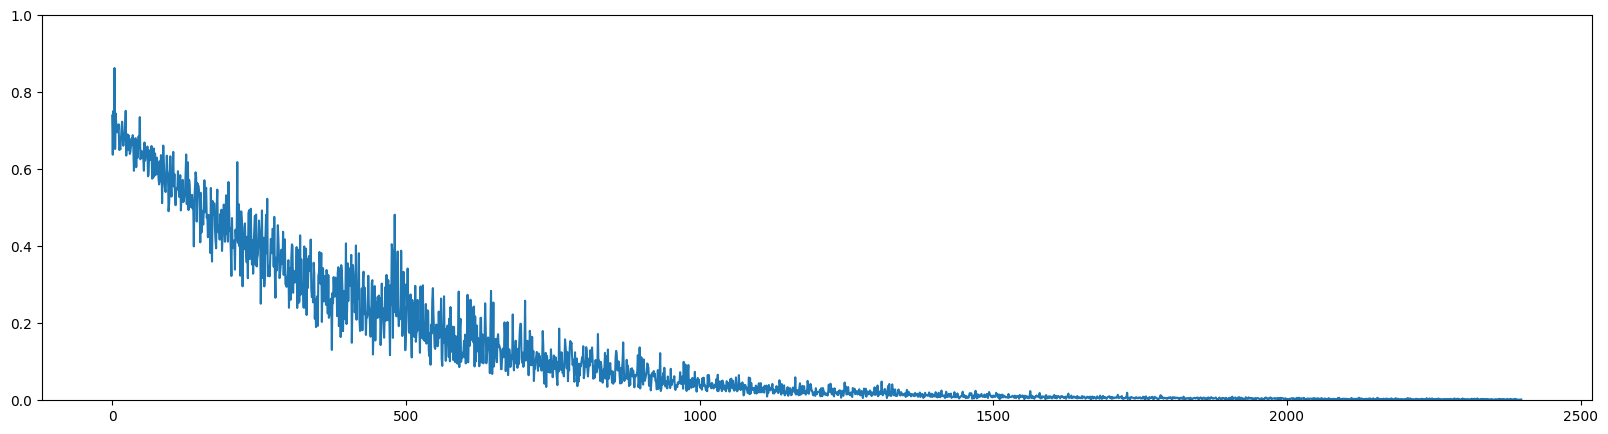

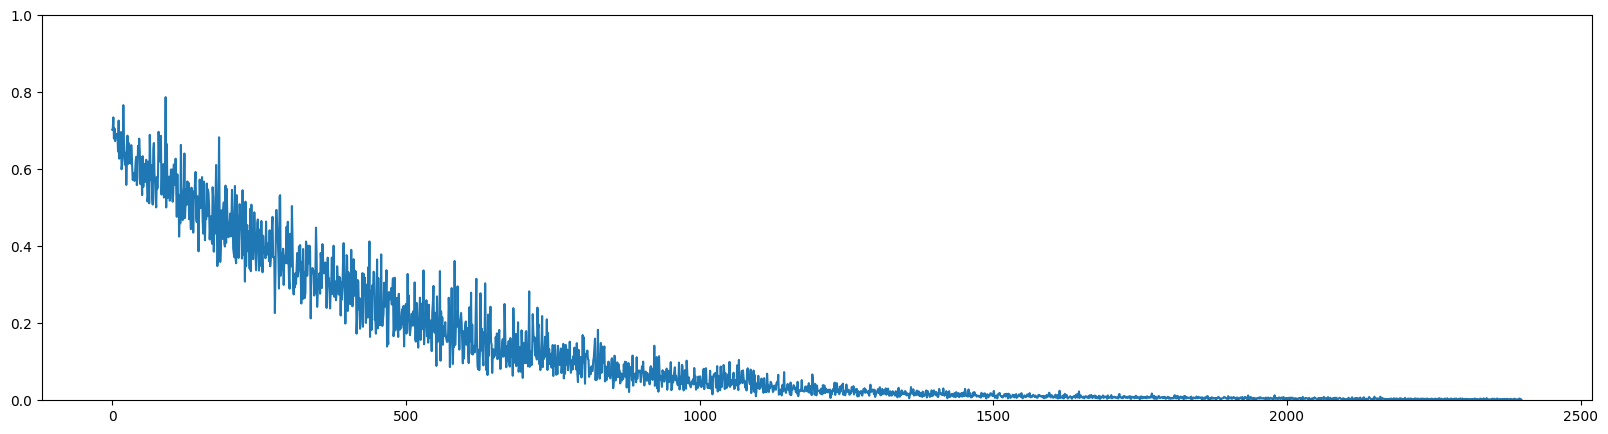

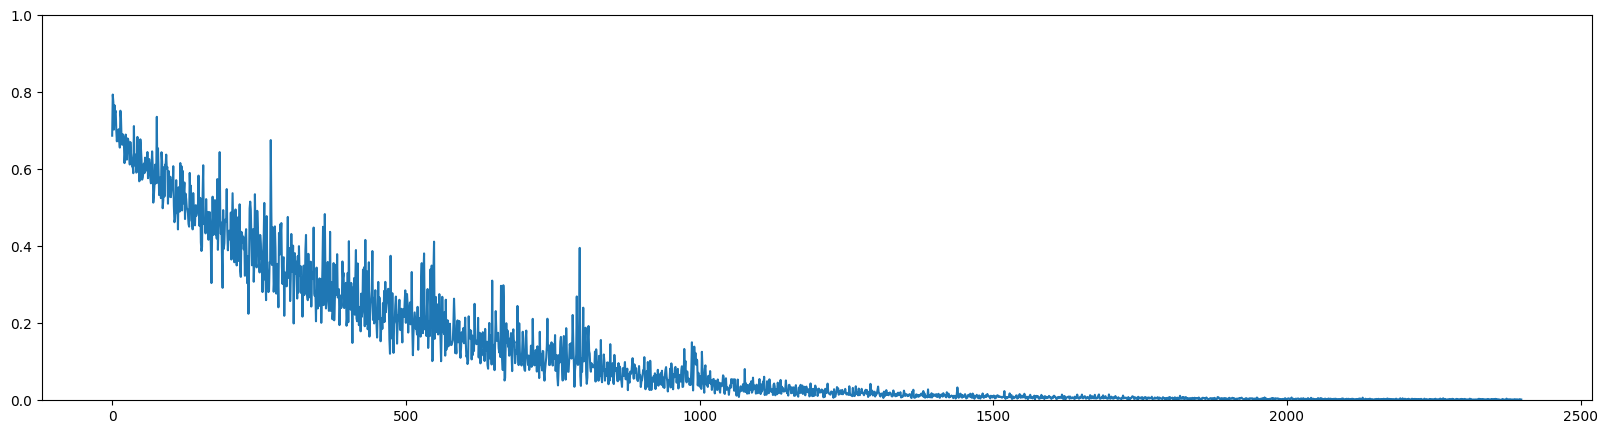

In [12]:
acc = [train_and_evaluate() for i in range(5)]
np.mean(acc)